In [14]:
def __clear_env():
    for key in globals().keys():
        if not key.startswith("__"):# 排除系统内建函数
            globals().pop(key)
__clear_env
import example_pendulum
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
#import torchvision
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import csv
from torch.autograd import Variable

In [2]:
device = 'cuda:0'
data = example_pendulum.get_pendulum_data(10)
image = data['x']
image_t = data['dx']
image_tt = data['ddx']
angle = data['z']
angle_t = data['dz']
angle_tt = data['ddz']
print(image.shape)

(5000, 2601)


In [3]:
environment = "desktop"
loss_log = []
params = {}
params['learning_rate'] = 1e-7
params['epochs'] = 170
params['batch_size'] = 50
if environment == 'laptop':
    params['root_dir'] =R'C:\Users\87106\OneDrive\sindy\progress'
else:
    params['root_dir'] = R'E:\OneDrive\sindy\progress'
# save parameters
params['if_save'] = True
params['save_date'] = '3-31'
params['save_ver'] = '1'
#load parameters
params['load_date'] = '3-30'
params['load_ver'] = '1'
PATH = os.path.join(params['root_dir'], params['save_date'],params['save_ver'])
print(PATH)

E:\OneDrive\sindy\progress\3-31\1


In [4]:
class angle_predict(nn.Module):
    def __init__(self):
        super(angle_predict, self).__init__()
        self.fc1 = nn.Linear(2601, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 1)
    def forward(self, x):
        m = nn.ReLU()
        x = self.fc1(x)
        x = m(x)
        x = self.fc2(x)
        x = m(x)
        x = self.fc3(x)
        x = m(x)
        x = self.fc4(x)
        x = m(x)
        x = self.fc5(x) 
        return x
model = angle_predict().to(device)
model

angle_predict(
  (fc1): Linear(in_features=2601, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=1, bias=True)
)

In [5]:

for epoch in range(params['epochs']):
    opt = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    loss_sum = 0 
    count = 0 
    for i in range(len(data['z'])//params['batch_size']):
        image_temp = image[i*params['batch_size']:(i+1)*params['batch_size'],:]
        angle_temp = angle[i*params['batch_size']:(i+1)*params['batch_size']]
        for j in range(image_temp.shape[0]):
            input = Variable(torch.tensor(image_temp[j,:],dtype=torch.float32).to(device))
            angle_pre = model.forward(input)
            angle_true = torch.tensor(angle_temp[j],dtype=torch.float32).to(device)
            loss = torch.abs(angle_true - angle_pre)
            loss_sum += loss
            count += 1
            opt.zero_grad()
            loss.backward()
            opt.step()
    loss_log.append(loss_sum.item()/count)
    print('epoch: ', epoch+1, 'loss: ', loss_sum.item()/count)

epoch:  1 loss:  0.798679541015625
epoch:  2 loss:  0.794107373046875
epoch:  3 loss:  0.78857470703125
epoch:  4 loss:  0.781646337890625
epoch:  5 loss:  0.77321591796875
epoch:  6 loss:  0.7629544921875
epoch:  7 loss:  0.750708447265625
epoch:  8 loss:  0.736615966796875
epoch:  9 loss:  0.72003349609375
epoch:  10 loss:  0.700609375
epoch:  11 loss:  0.6798431640625
epoch:  12 loss:  0.657014794921875
epoch:  13 loss:  0.632209912109375
epoch:  14 loss:  0.604833154296875
epoch:  15 loss:  0.574488134765625
epoch:  16 loss:  0.543097509765625
epoch:  17 loss:  0.5111669921875
epoch:  18 loss:  0.47828125
epoch:  19 loss:  0.446590185546875
epoch:  20 loss:  0.416498876953125
epoch:  21 loss:  0.3863397216796875
epoch:  22 loss:  0.357300146484375
epoch:  23 loss:  0.3301546875
epoch:  24 loss:  0.3054068359375
epoch:  25 loss:  0.2824601318359375
epoch:  26 loss:  0.26117998046875
epoch:  27 loss:  0.2415358154296875
epoch:  28 loss:  0.2231987060546875
epoch:  29 loss:  0.2060344

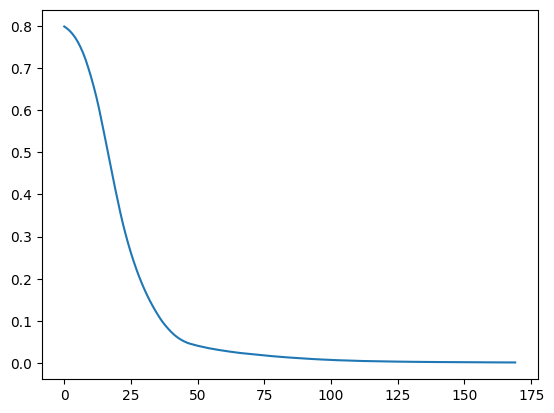

In [11]:
#plotting result
plt.plot(loss_log)
fig_PATH = os.path.join(PATH, 'loss.png') 
plt.savefig(fig_PATH, bbox_inches='tight', pad_inches = +0.1)
plt.show()

In [17]:
def saving(model,PATH):
    if os.path.exists(PATH) == False:
        os.makedirs(PATH)
    model_PATH = os.path.join(PATH, 'model.pt')
    torch.save(model.state_dict(), model_PATH)
    params_PATH = os.path.join(PATH, 'params.txt')
    with open(params_PATH, 'w') as f:
        f.write(str(params))
        f.close()
    loss_PATH = os.path.join(PATH, 'loss_log.csv')
    with open(loss_PATH, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(loss_log)
    #fig_PATH = os.path.join(PATH, 'loss.png') 
    #plt.savefig(fig_PATH)
    print("data saved")
    return

In [18]:
if params['if_save'] == True:
    saving(model,PATH)

data saved
